In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
import time
from datetime import timedelta

import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal, MOG
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConditionalFixedNorm, ConstrainedAnglesSigmoid, ResidualNetInput, ClampedAngles
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
def load_diabetes_dataset(device='cuda'):
    df = load_diabetes()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(df.data)
    y_np = scaler.fit_transform(df.target.reshape(-1, 1))[:, 0]
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    print(f"Norm coefficients: {np.linalg.norm(reg.coef_):.4f}")

    return X_tensor, y_tensor, X_np, y_np

In [4]:
def log_likelihood(beta: torch.Tensor, sigma: torch.Tensor, X: torch.Tensor, y: torch.Tensor, ):

    eps = 1e-7
    log_lk = - 0.5 * (y - beta @ X.T).square().sum(-1) / (sigma**2 + eps)
    log_lk_const = - X.shape[0] * torch.log((sigma + eps) * np.sqrt(2. * np.pi))

    return log_lk + log_lk_const


In [5]:
def build_cond_flow_manifold (flow_dim, q, n_layers=3, context_features=16, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features,
                                             context_features=context_features, num_blocks=5, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
            InverseTransform(
                ActNorm(features=flow_dim-1)
            )
        )

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    # transformation_layers.append(
    #     InverseTransform(
    #         ClampedAngles(eps=1e-3)
    #     )
    # )
    
    transformation_layers.append(
        InverseTransform(
            ConditionalFixedNorm(q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # define embedding (conditional) network
    embedding_net = ResidualNetInput(in_features=1, out_features=context_features, hidden_features=256,
                                    num_blocks=3, activation=torch.nn.functional.relu)

    # combine into a flow
    flow = Flow(transform, base_dist, embedding_net=embedding_net).to(device)
    
    return flow

In [6]:
def gen_cooling_schedule(T0, Tn, num_iter, scheme):
    def cooling_schedule(t):
        if t < num_iter:
            k = t / num_iter
            if scheme == 'exp_mult':
                alpha = Tn / T0
                return T0 * (alpha ** k)
            #elif scheme == 'log_mult':
            #    return T0 / (1 + alpha * math.log(1 + k))
            elif scheme == 'lin_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * k)
            elif scheme == 'quad_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * (k ** 2))
        else:
            return Tn
    return cooling_schedule

In [7]:
def train_cond_model(model, X, y, sigma, epochs=2_001, lr=1e-3, sample_size=1, context_size=1_000, norm_min_exp=-1, norm_max_exp=1., norm_min=-1, norm_max=1., T0=5, Tn=1e-2, iter_per_cool_step=20, device="cuda", **kwargs,):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # set up cooling schedule
    num_iter = epochs // iter_per_cool_step
    cooling_function = gen_cooling_schedule(T0=T0, Tn=Tn, num_iter=num_iter - 1, scheme='exp_mult')

    loss, loss_T = [], []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            T = cooling_function(epoch // (epochs / num_iter))
            optimizer.zero_grad()
            
            rand_norm = torch.rand(context_size).to(device)
            # log_uniform_norm = 10 ** (rand_norm * (norm_max_exp - norm_min_exp) + norm_min_exp).view(-1, 1)
            uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)

            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size, context=uniform_norm)
            if torch.any(torch.isnan(q_samples)): breakpoint()

            log_lik = log_likelihood(beta=q_samples, sigma=sigma, X=X, y=y)
            kl_div = torch.mean(q_log_prob - log_lik/ T)
            kl_div.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
            optimizer.step()

            loss.append(torch.mean(q_log_prob - log_lik).cpu().detach().numpy())
            loss_T.append(torch.mean(q_log_prob - log_lik/T).cpu().detach().numpy())
            print(f"Training loss at step {epoch}: {loss[-1]:.1f} and {loss_T[-1]:.1f} * (T = {T:.3f})")

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss, loss_T

In [8]:
def sample_beta(model, X, y, sigma, norm_min, norm_max, context_size=10, sample_size=100, n_iter=100, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    sample_list, kl_list, norm_list = [], [], []
    eps = 1e-7
    for _ in tqdm.tqdm(range(n_iter)):
        rand_norm = torch.rand(context_size).to(device)
        uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size, context=uniform_norm)
        sample_list.append(posterior_samples.cpu().detach().numpy())
        norm_list.append(uniform_norm.view(-1).cpu().detach().numpy())
        log_lik = log_likelihood(beta=posterior_samples, sigma=sigma, X=X, y=y)
        kl_div = log_probs_samples - log_lik
        kl_list.append(kl_div.cpu().detach().numpy())

    sample_list, norm_list, kl_list = np.concatenate(sample_list, 0), np.concatenate(norm_list, 0), np.concatenate(kl_list, 0)

    norm_sorted_idx = norm_list.argsort()
    samples_sorted, norm_sorted, kl_sorted = sample_list[norm_sorted_idx], norm_list[norm_sorted_idx], kl_list[norm_sorted_idx]

    return samples_sorted, norm_sorted, kl_sorted

In [488]:
device = 'cuda'
set_random_seeds(1234)

dir_name = "./plots/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# load data
X_tensor, y_tensor, X_np, y_np = load_diabetes_dataset(device=device)

# build model
flow_dim = X_tensor.shape[1]
q = 1
# flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)
flow = build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)

params = dict(q=q,
              sigma=torch.tensor(0.7),
              lr=1e-3,
              epochs=200,
              T0=20,
              Tn=1e-2,
              iter_per_cool_step=10,
              norm_min=0.01,
              norm_max=2,#.4
              sample_size=1,
              context_size=500,
              device=device)

R^2 score: 0.5177
Sigma regression: 0.6944
Norm coefficients: 0.8511


In [489]:
torch.autograd.set_detect_anomaly(False)
flow, loss, loss_T = train_cond_model(flow, X=X_tensor, y=y_tensor, **params)

Training loss at step 0: 854.2 and 52.0 * (T = 20.000)
Training loss at step 1: 666.2 and 43.6 * (T = 20.000)
Training loss at step 2: 599.6 and 41.1 * (T = 20.000)
Training loss at step 3: 600.6 and 41.3 * (T = 20.000)
Training loss at step 4: 599.6 and 40.3 * (T = 20.000)
Training loss at step 5: 610.4 and 40.8 * (T = 20.000)
Training loss at step 6: 595.5 and 39.1 * (T = 20.000)
Training loss at step 7: 606.8 and 39.7 * (T = 20.000)
Training loss at step 8: 595.8 and 39.4 * (T = 20.000)
Training loss at step 9: 589.0 and 39.2 * (T = 20.000)
Training loss at step 10: 586.7 and 53.4 * (T = 13.406)
Training loss at step 11: 582.9 and 53.6 * (T = 13.406)
Training loss at step 12: 575.5 and 53.2 * (T = 13.406)
Training loss at step 13: 573.1 and 53.4 * (T = 13.406)
Training loss at step 14: 570.0 and 53.7 * (T = 13.406)
Training loss at step 15: 570.3 and 53.7 * (T = 13.406)
Training loss at step 16: 576.2 and 53.9 * (T = 13.406)
Training loss at step 17: 576.3 and 53.6 * (T = 13.406)
Tr

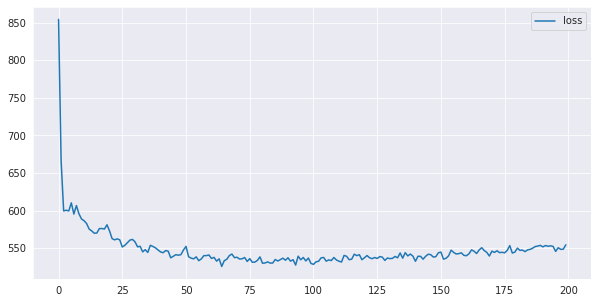

In [490]:
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [491]:
samples_sorted, norm_sorted, kl_sorted = sample_beta(flow, X_tensor, y_tensor, sigma=params['sigma'], norm_min=params['norm_min'], 
                                                     norm_max=params['norm_max'], context_size=1, sample_size=1000, n_iter=100, device='cuda')

100%|██████████| 100/100 [11:35<00:00,  6.95s/it]


In [492]:
def plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=1, a=0.95, folder_name='./'):
    if norm == 2:
        alphas_ridge = np.logspace(-2, 4, 2000)
        beta_sklearn = np.array(
            [Ridge(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_ridge)])
    else:
        alphas_lasso = np.logspace(-4, 2, 2000)
        beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso)])

    sklearn_norm = np.power(np.power(np.abs(beta_sklearn), norm).sum(1), 1 / norm)

    # sklearn_norm /= sklearn_norm.max()
    sklearn_sorted_idx = sklearn_norm.argsort()
    sklearn_norm = sklearn_norm[sklearn_sorted_idx]
    sklearn_sorted = beta_sklearn[sklearn_sorted_idx]

    l_quant = np.quantile(samples_sorted, 1 - a, axis=1)
    sample_mean = np.mean(samples_sorted, axis=1)
    r_quant = np.quantile(samples_sorted, a, axis=1)
    norm_sorted_ = norm_sorted / norm_sorted.max()

    clrs = sns.color_palette("husl", X_np.shape[-1])
    fig, ax = plt.subplots(figsize=(14, 14))
    with sns.axes_style("darkgrid"):
        for i in range(sample_mean.shape[-1]):
            color = clrs[i % X_np.shape[-1]]
            ax.plot(norm_sorted, sample_mean[:, i], c=color, alpha=0.7, linewidth=1.5)
            ax.fill_between(norm_sorted, l_quant[:, i], r_quant[:, i], alpha=0.2, facecolor=color)
            ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, c=color, alpha=0.7)

        # ax.set_xscale('log')
        plt.xlabel(f'$||\beta||_{{{norm}}}$', fontsize=18)
        plt.ylabel(r'$\beta$', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # plt.xscale('log')
        plt.savefig(f"{folder_name}beta_norm_T_001_.png", dpi=200, bbox_inches='tight')
        plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1439.40it/s]


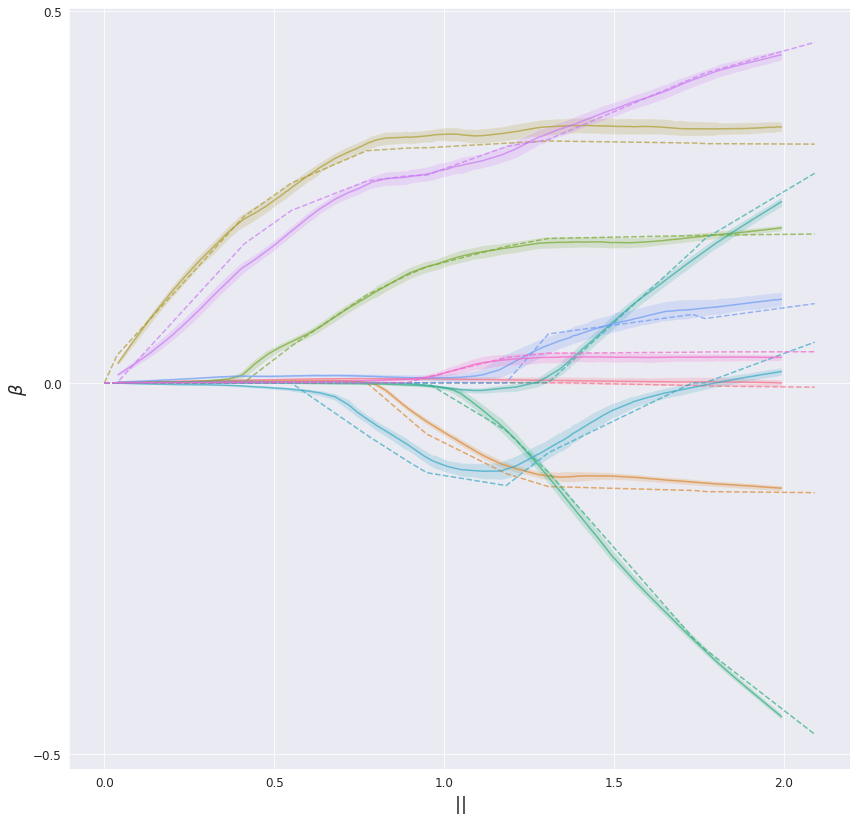

In [493]:
plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params['q'], a=0.95, folder_name=dir_name)

100%|██████████| 2000/2000 [00:01<00:00, 1519.40it/s]


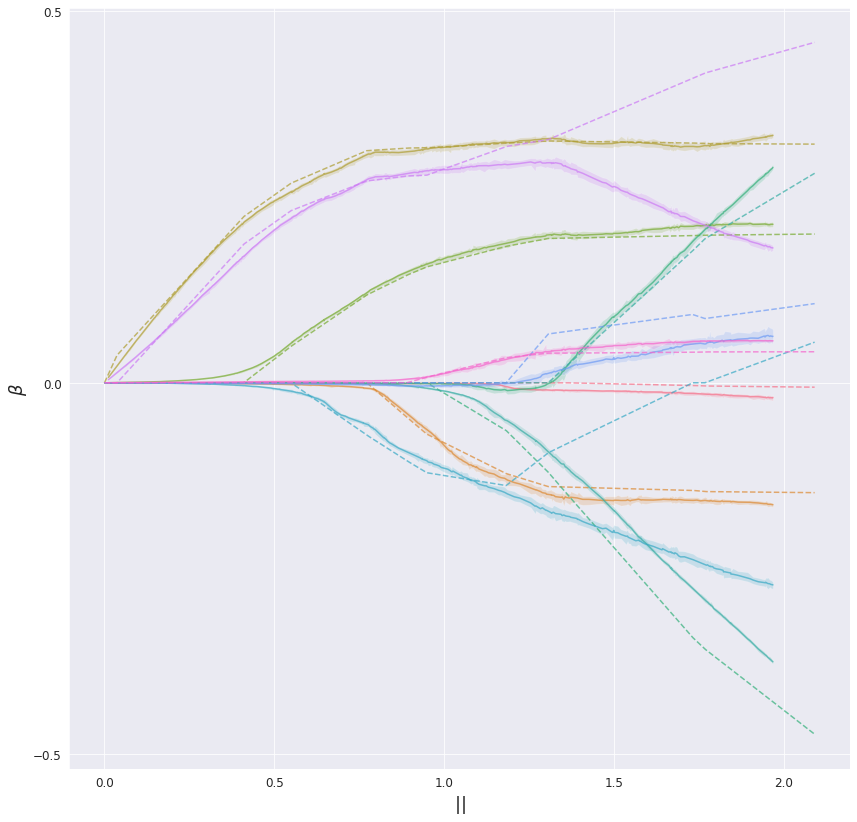

In [214]:
plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params['q'], a=0.95, folder_name=dir_name)

In [102]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
rstanarm = importr('rstanarm')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [290]:
data_df = pd.DataFrame(np.c_[y_np,X_np], 
                       columns = ['target','0','1','2','3','4','5','6','7','8','9'])

In [457]:
# Defining the R script and loading the instance in Python
from rpy2 import robjects
r = robjects.r
r['source']('bayes_lasso.R')# Loading the function we have defined in R.
bayes_function = robjects.globalenv['bayes_function']# Reading and processing data
bayes_function_opt_alpha  = (robjects.globalenv)['bayes_function_opt_alpha']# Reading and processing data

In [ ]:
alphas_lasso = np.logspace(-3, 1, 100)
coefs, ci_l, ci_r = [], [], []
conf = 0.95
for alpha in alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=alpha, chain=2)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)

100%|██████████| 100/100 [00:00<00:00, 1440.25it/s]


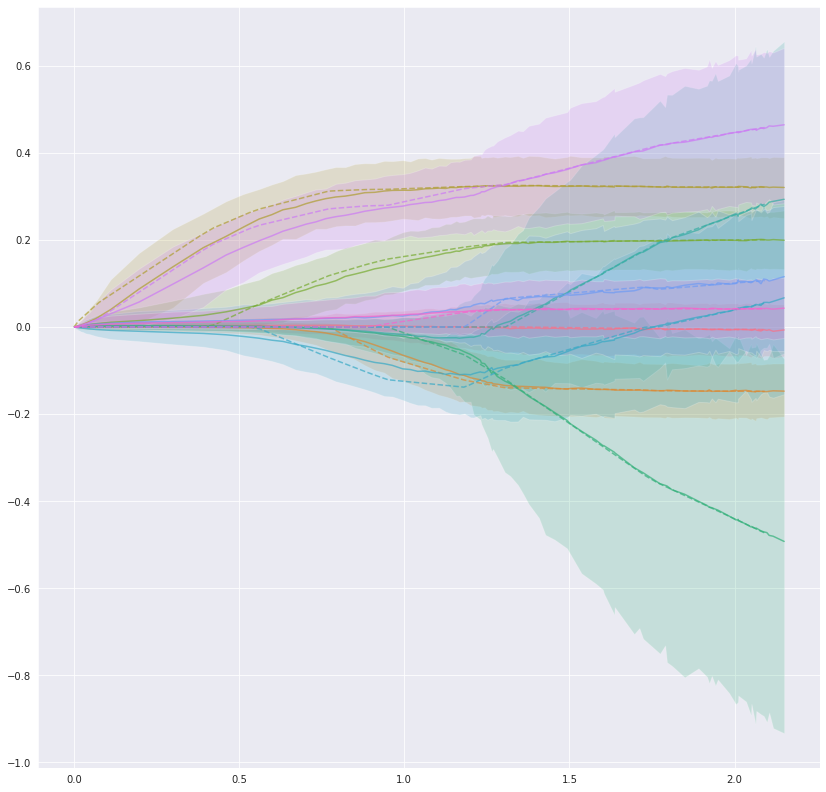

In [462]:
norm = 1.
beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso/X_np.shape[-1])])
sklearn_norm = np.power(np.power(np.abs(beta_sklearn), norm).sum(1), 1 / norm)

sklearn_sorted_idx = sklearn_norm.argsort()
sklearn_norm = sklearn_norm[sklearn_sorted_idx]
sklearn_sorted = beta_sklearn[sklearn_sorted_idx]

coefs_norm = np.power(np.power(np.abs(coefs), norm).sum(1), 1 / norm)
coefs_norm_idx = coefs_norm.argsort()
coefs_norm_sorted = coefs_norm[coefs_norm_idx]
coefs_sorted = coefs[coefs_norm_idx]
ci_l_sorted = ci_l[coefs_norm_idx]
ci_r_sorted = ci_r[coefs_norm_idx]

fig, ax = plt.subplots(figsize=(14, 14))
clrs = sns.color_palette("husl", X_np.shape[-1])
with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        color = clrs[i % X_np.shape[-1]]
        ax.plot(coefs_norm_sorted, coefs_sorted[:,i],alpha=0.7, linewidth=1.5, c=color)
        ax.fill_between(coefs_norm_sorted, ci_l_sorted[:,i], ci_r_sorted[:, i], alpha=0.2, facecolor=color)
        ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, alpha=0.7, c=color)
    plt.savefig("./plots/bayes_lasso.png", dpi=200, bbox_inches='tight')
    plt.show()

In [441]:
ci_l_sorted[-1,:], ci_r_sorted[-1, :]

(array([-0.06705432, -0.20551487,  0.24997382,  0.13307488, -0.93310911,
        -0.06057335, -0.15428902, -0.05510025,  0.2843133 , -0.02520257]),
 array([ 0.05177868, -0.08404363,  0.38985235,  0.26769436, -0.07365655,
         0.65612911,  0.29160736,  0.27811484,  0.641328  ,  0.11338618]))

100%|██████████| 50/50 [00:00<00:00, 1434.39it/s]


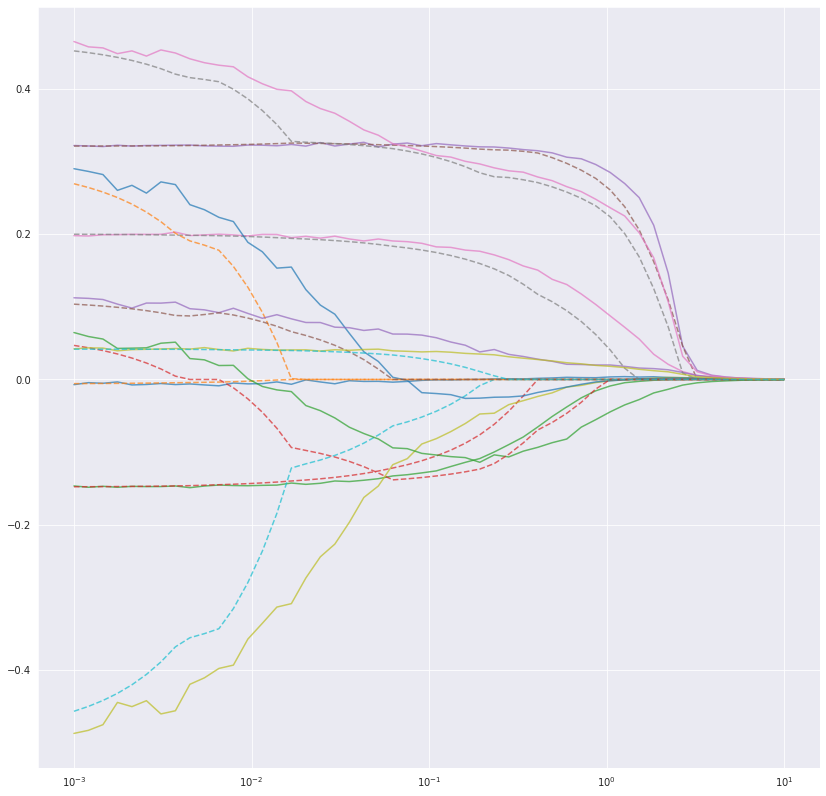

In [434]:
fig, ax = plt.subplots(figsize=(14, 14))
beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=True).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso/X_np.shape[1])])

with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        # color = [i % X_np.shape[-1]]
        ax.plot(alphas_lasso[::-1], coefs[:,i],alpha=0.7, linewidth=1.5)
        ax.plot(alphas_lasso, beta_sklearn[:, i], linestyle='--', linewidth=1.5, alpha=0.7)
        plt.xscale('log')

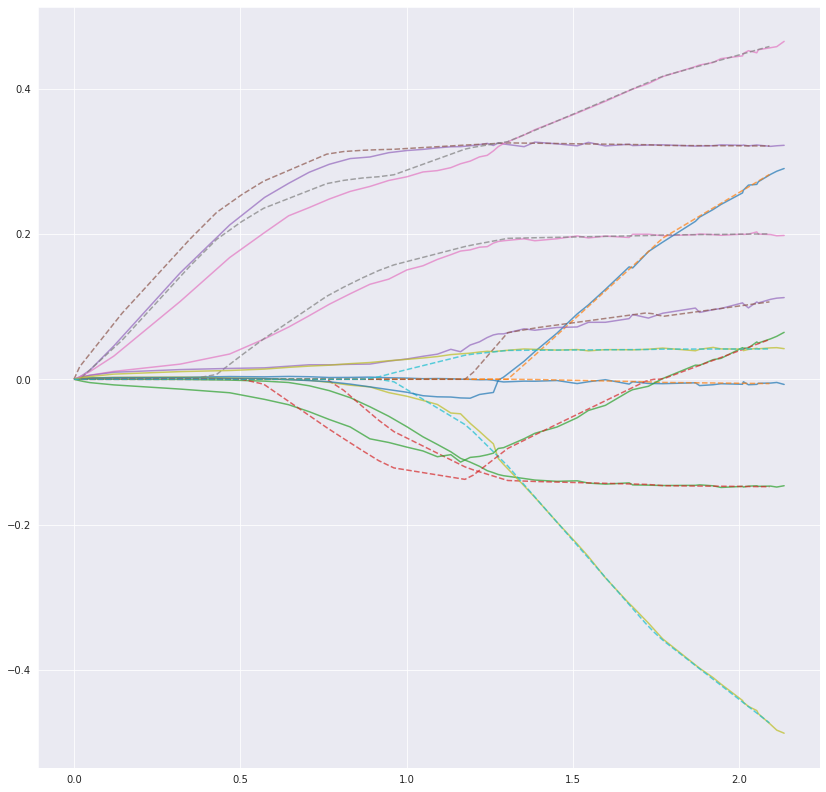

In [435]:
fig, ax = plt.subplots(figsize=(14, 14))
with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        # color = [i % X_np.shape[-1]]
        ax.plot(coefs_norm_sorted, coefs_sorted[:,i],alpha=0.7, linewidth=1.5)
        ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, alpha=0.7)

In [222]:
plt.show()